# Запуск Spark-сессии

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import when

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
def create_local_spark():
    """
    Создаёт SparkSession для локальной работы в Docker + JupyterLab.
    Оптимизировано под обработку больших parquet-файлов.
    """
    conf = (
        SparkConf()
        .setAppName("SOBD_Lab2_RandomForestClassifier2")
        .setMaster("local[*]")                   # использовать все ядра docker-контейнера
        .set("spark.driver.memory", "12g")       # подгоняем под систему
        .set("spark.executor.memory", "12g")
        .set("spark.sql.shuffle.partitions", "80")
        .set("spark.default.parallelism", "80")
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
        .set("spark.sql.execution.arrow.maxRecordsPerBatch", "500000")
        .set("spark.local.dir", "/tmp/spark-temp")
        .set("spark.ui.showConsoleProgress", "true")
    )

    return SparkSession.builder.config(conf=conf).getOrCreate()

spark = create_local_spark()
spark

# Загрузка датасета

In [4]:
df = spark.read.parquet("/home/jovyan/work/data/clean_taxi_data2.parquet")

df_10m = df.orderBy(rand()).limit(10_000_000).cache()
print("Строк в выборке:", df_10m.count())

Строк в выборке: 10000000


# Создание бинарной целевой переменной tip_given

In [6]:
df_ml = df_10m.withColumn(
    "tip_given",
    when(col("tip_amount") > 0, 1).otherwise(0)
)

# Выбор признаков

In [7]:
numeric_features = [
    "trip_distance",
    "passenger_count",
    "fare_amount",
    "extra",
    "mta_tax",
    "tolls_amount",
    "improvement_surcharge",
]

label_col = "tip_given"

In [8]:
to_double = numeric_features  # всё, что идёт в модель

for c in to_double:
    df_ml = df_ml.withColumn(c, col(c).cast("double"))

df_ml = df_ml.withColumn(label_col, col(label_col).cast("double"))

df_ml.printSchema()

root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- tip_given: double (nullable = false)



# Разделение данных

In [9]:
from pyspark.sql.functions import col

test_fraction = 0.2
fractions = {0.0: test_fraction, 1.0: test_fraction}

test_df = df_ml.sampleBy(label_col, fractions=fractions, seed=42)
train_df = df_ml.subtract(test_df)

print("Train rows:", train_df.count())
print("Test rows:", test_df.count())

print("Train distribution:")
train_df.groupBy(label_col).count().show()

print("Test distribution:")
test_df.groupBy(label_col).count().show()

Train rows: 7916221
Test rows: 2002145
Train distribution:
+---------+-------+
|tip_given|  count|
+---------+-------+
|      1.0|5213475|
|      0.0|2702746|
+---------+-------+

Test distribution:
+---------+-------+
|tip_given|  count|
+---------+-------+
|      1.0|1317455|
|      0.0| 684690|
+---------+-------+



# Проверка распределения в train (до баланса)

In [10]:
train_df.groupBy("tip_given").count().show()

+---------+-------+
|tip_given|  count|
+---------+-------+
|      1.0|5213475|
|      0.0|2702746|
+---------+-------+



In [12]:
#Разделяем train по классам
train_0 = train_df.filter(col("tip_given") == 0.0)
train_1 = train_df.filter(col("tip_given") == 1.0)

cnt_0 = train_0.count()
cnt_1 = train_1.count()

print("Class 0:", cnt_0)
print("Class 1:", cnt_1)

Class 0: 2702746
Class 1: 5213475


In [13]:
#Undersampling большего класса
# определяем, какой класс больше
if cnt_1 > cnt_0:
    major_df = train_1
    minor_df = train_0
else:
    major_df = train_0
    minor_df = train_1

ratio = minor_df.count() / major_df.count()

major_down = major_df.sample(
    fraction=ratio,
    seed=42
)

train_balanced = major_down.union(minor_df)

In [14]:
train_balanced.groupBy("tip_given").count().show()

+---------+-------+
|tip_given|  count|
+---------+-------+
|      1.0|2704791|
|      0.0|2702746|
+---------+-------+



# Pipeline

## 1. Ассемблер числовых признаков

In [15]:
assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features"
)

# 2. Модель RandomForestClassifier

In [22]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    labelCol="tip_given",
    featuresCol="features",
    numTrees=50,
    maxDepth=15,
    seed=42
)

# 3. Финальный Pipeline

In [23]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[
    assembler,
    rf
])

# Обучение

In [24]:
model = pipeline.fit(train_balanced)
print("Модель RandomForestClassifier2 обучена")

Модель RandomForestClassifier2 обучена


# Предсказание

In [25]:
test_pred = model.transform(test_df)
test_pred.select("prediction", "probability", label_col).show(10, truncate=False)

+----------+----------------------------------------+---------+
|prediction|probability                             |tip_given|
+----------+----------------------------------------+---------+
|1.0       |[0.4647275588480263,0.5352724411519737] |1.0      |
|0.0       |[0.5091921391264892,0.4908078608735108] |1.0      |
|0.0       |[0.5270748816856111,0.47292511831438894]|1.0      |
|0.0       |[0.5316198308697926,0.46838016913020736]|1.0      |
|1.0       |[0.4557296430667443,0.5442703569332557] |1.0      |
|1.0       |[0.47914531766872925,0.5208546823312709]|1.0      |
|0.0       |[0.5735115579733898,0.42648844202661024]|1.0      |
|1.0       |[0.43662029070192154,0.5633797092980785]|0.0      |
|1.0       |[0.4682522258637433,0.5317477741362567] |1.0      |
|1.0       |[0.4771789023686975,0.5228210976313025] |1.0      |
+----------+----------------------------------------+---------+
only showing top 10 rows



# Метрики

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Multiclass-метрики (работают для бинарной задачи)
evaluator_multi = MulticlassClassificationEvaluator(
    labelCol="tip_given",
    predictionCol="prediction"
)

accuracy = evaluator_multi.setMetricName("accuracy").evaluate(test_pred)
precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(test_pred)
recall = evaluator_multi.setMetricName("weightedRecall").evaluate(test_pred)
f1 = evaluator_multi.setMetricName("f1").evaluate(test_pred)

#ROC-AUC
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="tip_given",
    rawPredictionCol="rawPrediction",   
    metricName="areaUnderROC"
)

auc = evaluator_auc.evaluate(test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", auc)

Accuracy: 0.5725893978707836
Precision: 0.5918089882098114
Recall: 0.5725893978707836
F1 Score: 0.579968408971383
ROC-AUC: 0.5695903523189745


# Матрица ошибок

In [27]:
cm = test_pred.groupBy(label_col, "prediction").count()
cm.show()

+---------+----------+------+
|tip_given|prediction| count|
+---------+----------+------+
|      1.0|       1.0|825311|
|      1.0|       0.0|492144|
|      0.0|       1.0|363594|
|      0.0|       0.0|321096|
+---------+----------+------+



# ROC-кривая

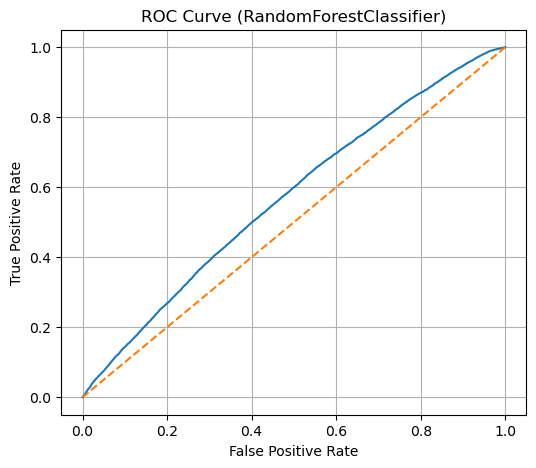

In [28]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import rand
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

pred = test_pred.withColumn("prob1", vector_to_array("probability")[1])

sample = pred.select("prob1", label_col).orderBy(rand()).limit(50000)
rows = sample.collect()

y_true = [r[label_col] for r in rows]
y_score = [r["prob1"] for r in rows]

fpr, tpr, _ = roc_curve(y_true, y_score)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (RandomForestClassifier)")
plt.grid(True)
plt.show()

# Сохранение модели

In [29]:
save_path = "/home/jovyan/work/models/rf_pipeline_model_fixed"
model.write().overwrite().save(save_path)
print("Модель сохранена в:", save_path)

Модель сохранена в: /home/jovyan/work/models/rf_pipeline_model_fixed
